In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

%run utils.py

In [2]:
# read geodata of hk
dcca = gpd.read_file("../data/DCCA_21C.geojson").to_crs(epsg=4326)
create_features(dcca)

## 1. Find potential candidate locations utilizing experience from other brands' restaurants

We collected the locations of all the restaurants of the following brands:

- McDonald's
- Fairwood
- Cafe de Coral
- KFC

We remove locations of other brands within 1km of Yoshinoya's restaurants. The remaining locations are potential candidate locations for Yoshinoya's new restaurants.

Meanwhile, we also calculate the metric=(Median monthly income)*(Working Population) to evaluate the potential purchasing power of each location.

In [3]:
# set the hyperparameters
dmin = 1000
gamma = .8
ws = .2
wp = .8

In [4]:
# read geodata of yoshinoya
yoshi = read_json_data("../data/yoshinoya.json",drop_duplicates=True)
yoshi = set_zone(yoshi,radius=dmin)

In [5]:
others_path = {
    "Fairwood":"../data/fairwood.json",
    "Cafe de Coral":"../data/cdc.json",
    "McDonald's":"../data/mcdonalds.json",
    "KFC":"../data/kfc.json",
}

store_color = {
    "Fairwood":"white",
    "Cafe de Coral":"orange",
    "McDonald's":"yellow",
    "KFC":"red",
}

In [6]:
others_dfs = {}
for name in others_path:
    others_dfs[name] = read_json_data(others_path[name])

In [7]:
others_geometry = concat_geometry(others_dfs.values())
yoshi_zone = yoshi.set_geometry('zone')
difference = dcca.overlay(yoshi_zone,how='difference')
candidates_location = others_geometry.loc[~others_geometry.apply(lambda x: x.within(yoshi_zone.geometry).any())]
hk_boundary = gpd.GeoSeries(difference.unary_union).boundary

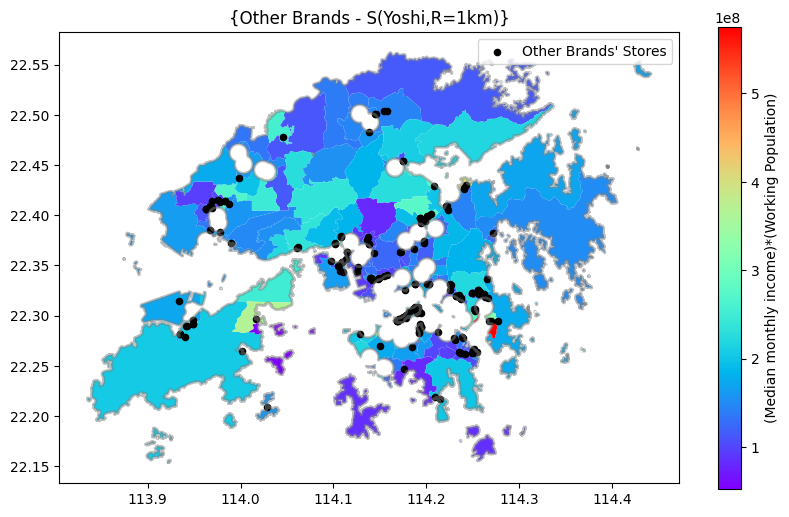

In [8]:
S = 10
fig,ax=plt.subplots(figsize=(S,S))
difference.plot('t_tmmearn',cmap="rainbow",ax=ax,legend=True,legend_kwds={'label': "(Median monthly income)*(Working Population)",'shrink':.6})
hk_boundary.plot(color="grey",ax=ax,lw=2,alpha=.5)
candidates_location.plot(color="k",ax=ax,markersize=2*S,label="Other Brands' Stores")
ax.set_title("{Other Brands - S(Yoshi,R=1km)}")
ax.legend()
plt.show()

## 2. Model and calculate value of each candidate location

Define the feature of each candidate and current yoshinoya as the feature of the corresponding district in dataset "DCCA_21C.json" which includes data of demography and incomes. 

First, let us define the "Modified Similiarity Score" $S$ between the feature of $i^{th}$ feature $Y_i$ and the average feature of current yoshinoya $\bar{X}$ as:

$$
S(Y_i) = \cos(Y_i,\bar{X})\cdot\sqrt{\frac1{\gamma}\frac{d_i}{d_{\min}}-1}
$$

where $\cos(\cdot,\cdot)$ is the cosine similarity function, $d_i$ is the distance between candidate location and the nearest current yoshinoya, and $d_{\min}$ is the excluded distance and the $\gamma$ is a hyparameter for closeness penalty. 

This the "Modified Similiarity Score" measures how the candidate match the historical standard of stores' location choosing of yoshinoya.

Second, we define the "Potential Purchasing Power" $P$ of each candidate location as:

$$
P(Y_i) = I_i*W_i
$$

where $I_i$ is the median monthly income of the $i^{th}$ candidate location and $W_i$ is the working population of the $i^{th}$ candidate location.

Then, we define the "Value" $V$ of each candidate location as:

$$
V(Y_i) = \omega_S S(Y_i) + \omega_P \frac{P(Y_i)}{R(Y_i)}
$$

where $R(Y_i)$ is the average rent of the $i^{th}$ candidate location,
$\omega_S$ and $\omega_P$ are hyparameters for the weight of "Modified Similiarity Score" and "Potential Purchasing Power" respectively.

Finally, we rank the candidates by their "Value" and select the top 5 candidates as the final recommendation.

In [9]:
rent = gpd.read_file("../data/Shop_and_Other_Commercial_Assessments.geojson").to_crs(epsg=4326)
geodata = gpd.overlay(dcca, rent, how='intersection')
geodata['Shop_RV_HKD_In_Thousand'] = geodata['Shop_RV_HKD_In_Thousand'].astype(float)
geodata['Shop_Number'] = geodata['Shop_Number'].astype(float)
geodata['avg_rent'] = geodata['Shop_RV_HKD_In_Thousand']/geodata['Shop_Number']

In [10]:

geodata_normed = minmax_normalize(geodata)
yoshi_features = get_features_by_location(geodata_normed,yoshi.geometry)
candidate_features = get_features_by_location(geodata_normed,candidates_location)
yoshi_common_feature = yoshi_features.mean()
sim = cosine_similarity(candidate_features,yoshi_common_feature)
distance = min_distance(candidates_location,yoshi)

/Users/creator/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [11]:
candidates = gpd.GeoDataFrame({"s":sim,"d":distance,"geometry":candidates_location,**candidate_features.to_dict()})
candidates['S'] = candidates.s*np.sqrt(1/gamma*candidates.d/dmin-1)
candidates['P'] = candidates.t_tmmearn
candidates['R'] = candidates.avg_rent
candidates['V'] = ws*candidates.S+wp*candidates.P/candidates.R

In [12]:
candidates

,s,d,geometry,adhz,age_1,age_2,age_3,age_4,age_5,born_chi,...,den_pop,den_income,OBJECTID,Shop_Number,Shop_RV_HKD_In_Thousand,avg_rent,S,P,R,V
0,0.919083,1233.128249,POINT (114.22598 22.32540),0.409091,0.212630,0.296960,0.175595,0.497526,0.927276,0.681769,...,0.095695,0.065144,0.142857,1.000000,1.000000,0.264146,0.676266,0.118183,0.264146,0.493185
2,0.923826,1949.456053,POINT (114.25616 22.32517),0.409091,0.115458,0.100434,0.205551,0.290146,0.573023,0.398017,...,0.233927,0.159294,0.142857,1.000000,1.000000,0.264146,1.107366,0.098021,0.264146,0.518341
3,0.891458,1547.061874,POINT (114.25745 22.32174),0.545455,0.370402,0.243214,0.134537,0.443375,0.124527,0.142649,...,0.225271,0.296996,0.142857,1.000000,1.000000,0.264146,0.861458,0.306006,0.264146,1.099069
9,0.976457,1046.004751,POINT (114.14428 22.50080),0.409091,0.378694,0.476113,0.307225,0.656371,0.381949,0.439410,...,0.295156,0.241288,0.142857,1.000000,1.000000,0.264146,0.541477,0.242343,0.264146,0.842262
11,0.830411,1612.357053,POINT (114.20119 22.39872),0.681818,0.212418,0.459826,0.165022,0.371039,0.270771,0.190502,...,0.014149,0.016308,0.142857,1.000000,1.000000,0.264146,0.836800,0.278838,0.264146,1.011856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,0.926045,1461.279955,POINT (114.19828 22.39427),0.545455,0.620030,0.376221,0.446079,0.712930,0.326360,0.280659,...,0.009898,0.010528,0.142857,1.000000,1.000000,0.264146,0.841937,0.428255,0.264146,1.465413
628,0.948274,1140.460274,POINT (114.14332 22.36223),0.454545,0.328514,0.337134,0.219824,0.544592,0.778243,0.614083,...,0.100360,0.068322,0.142857,1.000000,1.000000,0.264146,0.618617,0.141533,0.264146,0.552373
633,0.826520,1187.072807,POINT (114.11321 22.35675),0.227273,0.142037,0.017372,0.148282,0.191737,0.286113,0.155750,...,0.022433,0.027020,0.095238,0.223494,0.243079,0.311799,0.574917,0.218849,0.311799,0.676497
646,0.938365,1882.287286,POINT (113.98782 22.41088),0.636364,0.291729,0.465798,0.382643,0.614253,0.471209,0.694869,...,0.073880,0.051977,0.142857,1.000000,1.000000,0.264146,1.091435,0.183708,0.264146,0.774671


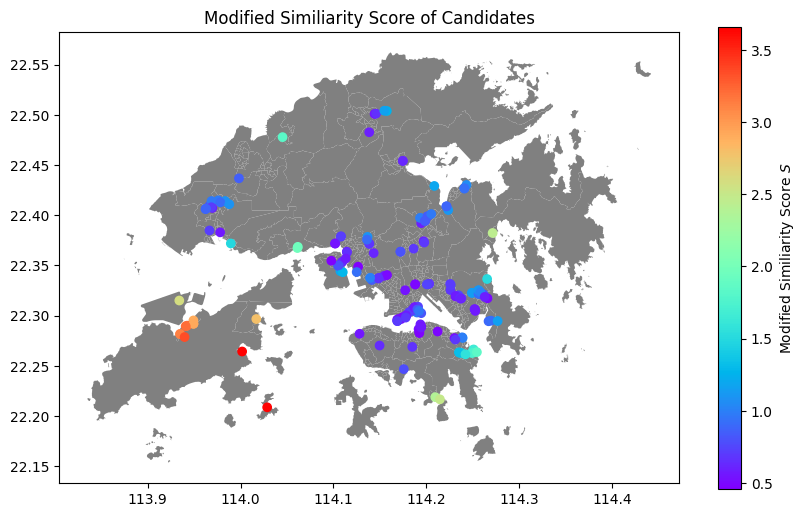

In [13]:
S = 10
fig,ax=plt.subplots(figsize=(S,S))
dcca.plot(color="grey",ax=ax)
candidates.plot("S",cmap="rainbow",ax=ax,legend=True,legend_kwds={'label': "Modified Similiarity Score $S$",'shrink':.6})
ax.set_title("Modified Similiarity Score of Candidates")
plt.show()

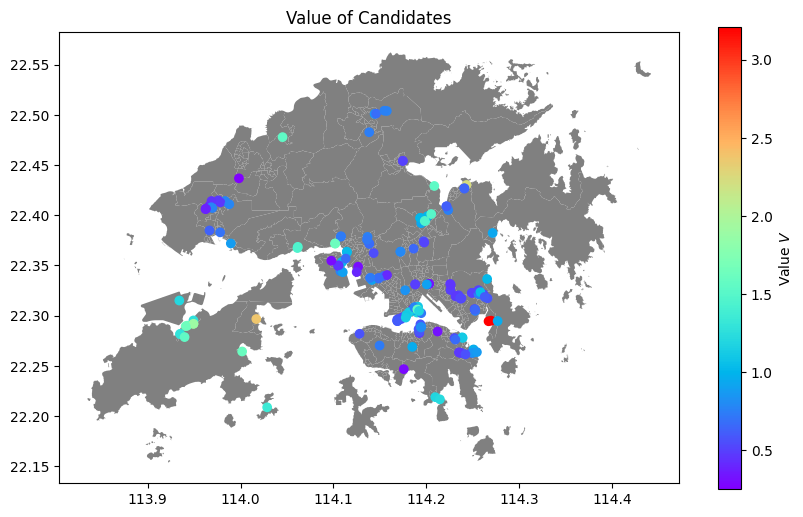

In [14]:
S = 10
fig,ax=plt.subplots(figsize=(S,S))
dcca.plot(color="grey",ax=ax)
candidates.plot("V",cmap="rainbow",ax=ax,legend=True,legend_kwds={'label': "Value $V$",'shrink':.6})
ax.set_title("Value of Candidates")
plt.show()